# 02 - Data Augmentation for Crop Disease Classification

## Goals of this Notebook

- Load the cleaned and split dataset we prepared earlier
- Apply data augmentation to improve model generalization
- Understand the augmentation strategies (flip, rotate, jitter, normalization)
- Visualize some transformed images to ensure augmentations are applied correctly

---

## Why Data Augmentation?

Data augmentation artificially increases the diversity of our training dataset by applying random transformations.  
This helps the model generalize better to unseen images by exposing it to variations like:

- Different leaf orientations (rotation, flips)
- Different lighting conditions (brightness, contrast adjustments)
- Slight noise in colors (saturation, hue jitter)

In this project, we aim for **light augmentations** because leaf disease textures are subtle and important to preserve.

---

# STEP 1: Ensure that Augmentation Pipeline Works

In [3]:
# 📚 Imports
import os
import sys
import random
import matplotlib.pyplot as plt
from PIL import Image

current_dir = os.getcwd()
print(f"[DEBUG] Current working directory: {current_dir}")

project_root = os.path.dirname(current_dir)
if project_root not in sys.path:
    sys.path.append(project_root)
print(f"[DEBUG] Project root added to sys.path: {project_root}")

from src.data.augment import AugmentationPipeline  # ✅ from augment.py
from src.utils.config import SPLIT_DIR

# 📦 Initialize Augmentation Pipeline
augmenter = AugmentationPipeline()

# 🔍 Available transforms
train_transforms = augmenter.get_transforms(phase="train")
val_transforms   = augmenter.get_transforms(phase="val")
test_transforms  = augmenter.get_transforms(phase="test")

print("[INFO] Data augmentation pipeline loaded successfully.")

[DEBUG] Current working directory: /Users/mitra/vibe_code/CropGuard/notebooks
[DEBUG] Project root added to sys.path: /Users/mitra/vibe_code/CropGuard
[INFO] Data augmentation pipeline loaded successfully.


# STEP 2 : Visualizing Augmented Images

We will now pick a few random images from the training split,  
apply our training-time augmentations,  
and plot them side-by-side.

---

**Important:**  
- Training images get heavy augmentations (flip, rotation, jitter, etc.)  
- Validation and Test images are only normalized, without random distortions.

In [5]:
# 🛠 Helper function to load random image and apply transformation
def visualize_augmented_samples(crop="tomato", n_samples=5):
    """
    Randomly selects n_samples from a crop, applies augmentations, and plots them.
    """
    split = "train"
    crop_dir = os.path.join(SPLIT_DIR, split, crop)
    disease_classes = os.listdir(crop_dir)
    disease_class = random.choice(disease_classes)

    disease_path = os.path.join(crop_dir, disease_class)
    images = [img for img in os.listdir(disease_path) if img.lower().endswith(('.jpg', '.jpeg', '.png'))]

    selected_images = random.sample(images, min(n_samples, len(images)))

    fig, axes = plt.subplots(1, len(selected_images), figsize=(20, 5))
    fig.suptitle(f"Augmented Samples - {crop.capitalize()} ({disease_class})", fontsize=16)

    for idx, img_name in enumerate(selected_images):
        img_path = os.path.join(disease_path, img_name)
        img = Image.open(img_path).convert("RGB")

        transformed_img = train_transforms(img)
        transformed_img = transformed_img.permute(1, 2, 0)  # (C, H, W) ➔ (H, W, C) for plotting
        transformed_img = transformed_img * torch.tensor(augmenter.std) + torch.tensor(augmenter.mean)  # Unnormalize
        transformed_img = transformed_img.clip(0, 1)

        axes[idx].imshow(transformed_img)
        axes[idx].axis('off')

    plt.tight_layout()
    plt.show()

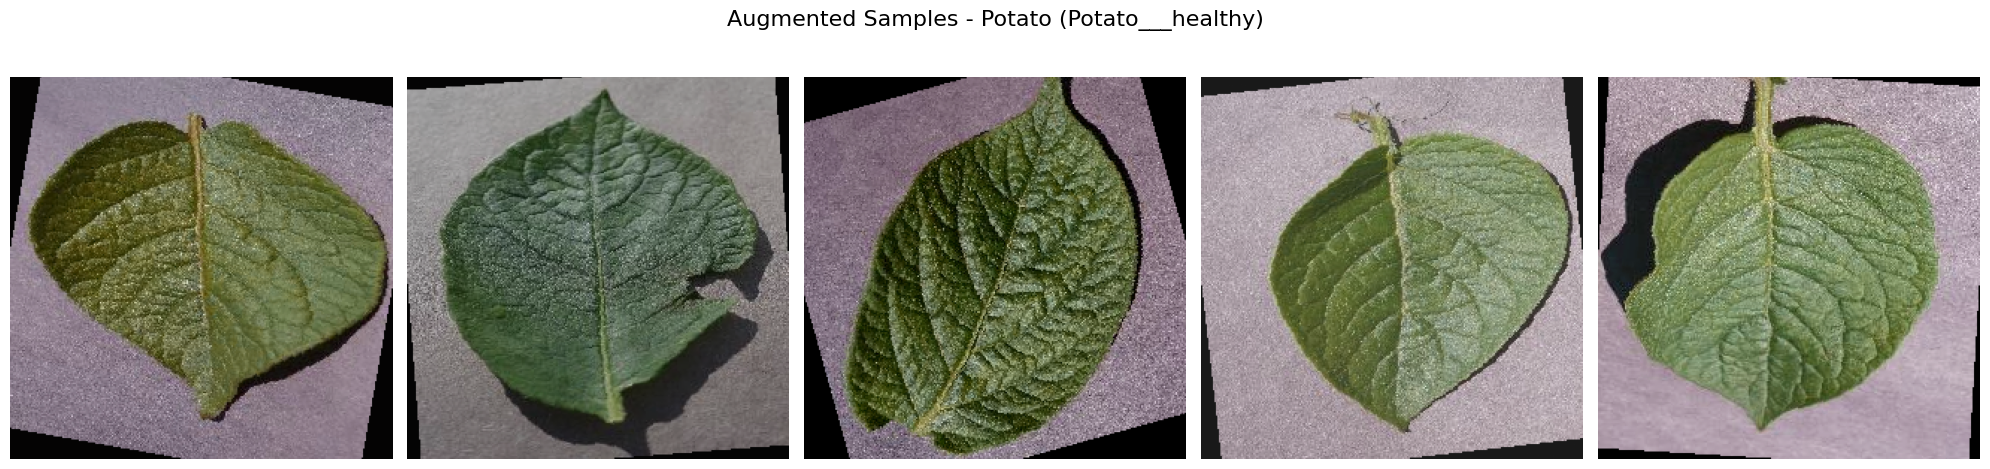

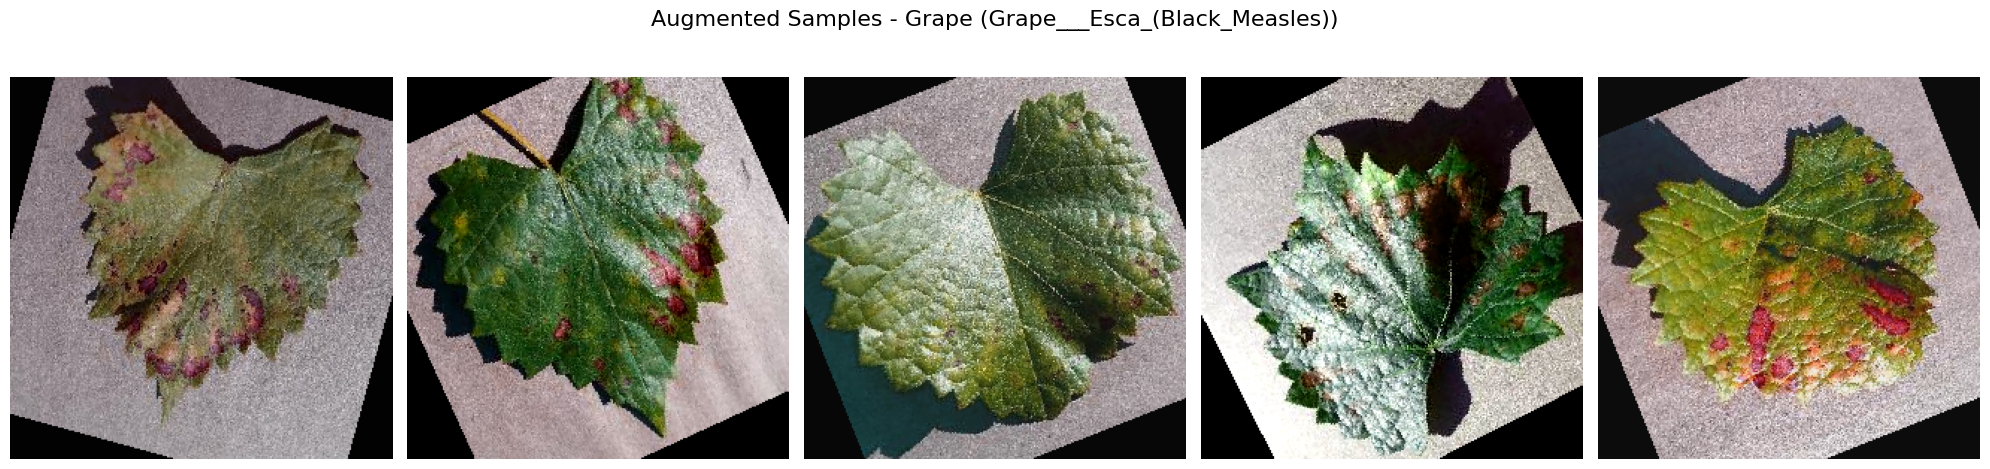

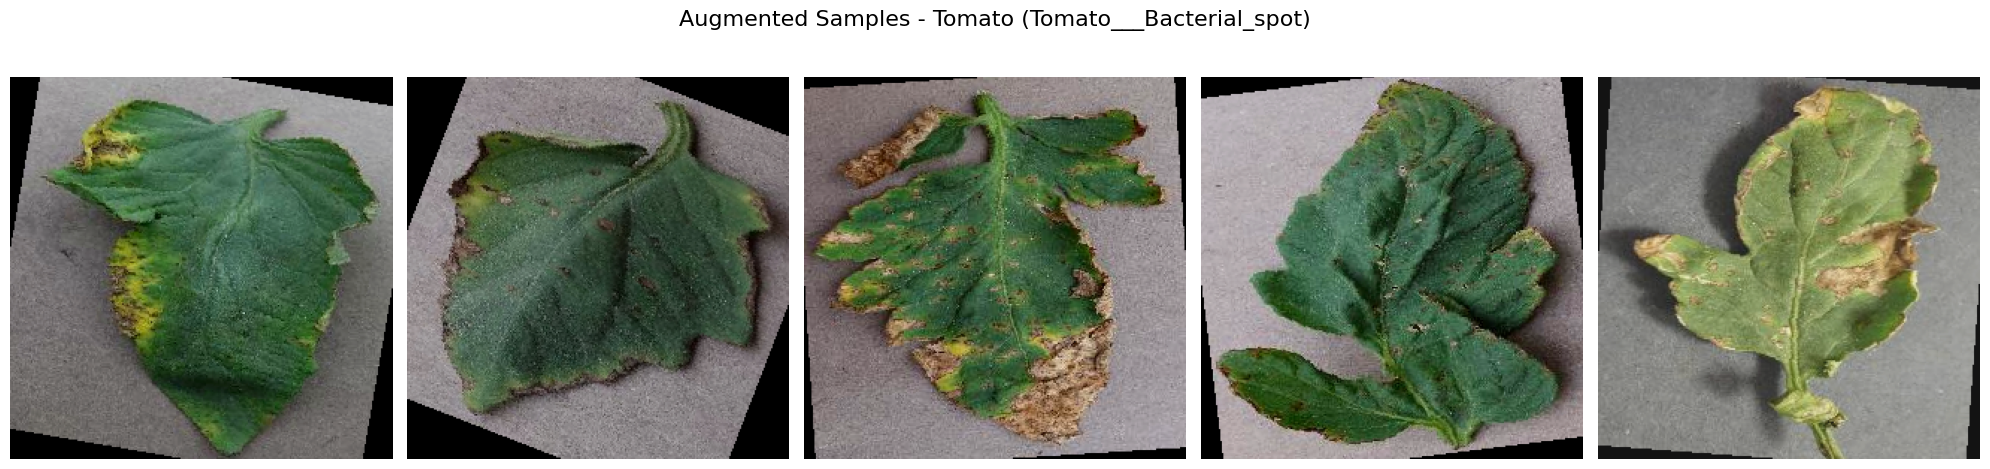

In [6]:
# 🔥 Run for each crop
import torch

for crop_name in ["potato", "grape", "tomato"]:
    visualize_augmented_samples(crop=crop_name, n_samples=5)

# 📋 Summary of This Notebook

- We modularized the data augmentation logic using a dedicated `AugmentationPipeline` class.
- Applied standard image transformations like:
  - Random horizontal/vertical flips
  - Random rotations
  - Color jitter (brightness, contrast, saturation, hue)
  - Normalization using ImageNet mean and std
- Visualized the effect of augmentations on multiple random examples.
- Confirmed that the augmented images maintain meaningful disease texture while introducing natural variability.

---

**Our data is now ready for training models in the next phase!**  
Next step: Implement Dataset and DataLoader classes to feed data into our deep learning models.

---

In [10]:
from src.data.dataset import PlantVillageDataset
from src.data.augment import AugmentationPipeline
from src.utils.config import TRAIN_DIR, VAL_DIR

# Set up transform
transforms = AugmentationPipeline()

train_ds = PlantVillageDataset(
    root_dir=TRAIN_DIR,
    transform=transforms.get_transforms("train")
)

val_ds = PlantVillageDataset(
    root_dir=VAL_DIR,
    transform=transforms.get_transforms("val")
)

[INFO] 17056 images found across 17 classes.
[INFO] 3649 images found across 17 classes.
